In [1]:
monitor='val_accuracy'
epochs=120
batch_size=32
input_shape=(128, 128, 3) # please resize it to (224,224,3) if you have enough RAM
Verbose=True

In [2]:
#apt-get install git python3-opencv
import os

if not os.path.isdir('k'):
  !git clone https://github.com/joaopauloschuler/k-neural-api.git k
else:
  !cd k && git pull

!cd k && pip install .

!rm -rf k

Cloning into 'k'...
remote: Enumerating objects: 1832, done.
remote: Counting objects: 100% (244/244), done.
remote: Compressing objects: 100% (169/169), done.
remote: Total 1832 (delta 152), reused 152 (delta 71), pack-reused 1588
Receiving objects: 100% (1832/1832), 15.73 MiB | 7.70 MiB/s, done.
Resolving deltas: 100% (1265/1265), done.
Processing /kaggle/working/k
  Preparing metadata (setup.py) ... done
  Created wheel for cai: filename=cai-0.1.7-py3-none-any.whl size=61378 sha256=0d629218fbcdce50a63b4d3b5d836bce481a6bc2f078c7c2d72f070cea2b72cc
  Stored in directory: /tmp/pip-ephem-wheel-cache-wen_pr1x/wheels/7f/63/1a/ed2b6234f76aae55efe76492246448486e41178bd0b5682ecf
Successfully built cai


In [3]:
import sys
print("Python version:", sys.version)

import skimage
print('skimage:',  skimage.__version__)

import tensorflow as tf
print('Tensorflow:',tf.__version__)

import cai
import cai.datasets
import cai.models

import multiprocessing
import os

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

Python version: 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]
skimage: 0.21.0


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Tensorflow: 2.13.0


In [4]:
data_dir = "/kaggle/input/plantvillage-dataset/color"

label_of_classes = os.listdir(data_dir)
print("Classes Lables:", label_of_classes)

number_of_classes = len(label_of_classes)
print("Number of Classes:", number_of_classes)

Classes Lables: ['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Potato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Strawberry___Leaf_scorch', 'Peach___healthy', 'Apple___Apple_scab', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Black_rot', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___Bacterial_spot', 'Apple___Cedar_apple_rust', 'Tomato___Target_Spot', 'Pepper,_bell___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Late_blight', 'Tomato___Tomato_mosaic_virus', 'Strawberry___healthy', 'Apple___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Raspberry___healthy', 'Tomato___Leaf_

In [5]:
train_x, val_x, test_x, train_y, val_y, test_y, classweight, classes = cai.datasets.load_images_from_folders(
    seed=7,
    root_dir=data_dir,
    lab=True,
    verbose=Verbose,
    bipolar=False,
    base_model_name='plant_leaf',
    training_size=0.6,
    validation_size=0.2,
    test_size=0.2,
    target_size=(input_shape[0],input_shape[1]),
    has_training=True,
    has_validation=True,
    has_testing=True,
    smart_resize=True
)

Loading  38  classes.
smart resize is enabled.
loading train images
train shape is: (32571, 128, 128, 3)
loading validation images
validation shape is: (10858, 128, 128, 3)
loading test images
test shape is: (10876, 128, 128, 3)
Channel  0  min: 0.0  max: 1.0
Channel  1  min: 0.2054719  max: 0.89584607
Channel  2  min: 0.2595902  max: 0.94278413
Loaded.


In [6]:
print(train_x.shape,val_x.shape,test_x.shape)
print(train_y.shape,val_y.shape,test_y.shape)

(32571, 128, 128, 3) (10858, 128, 128, 3) (10876, 128, 128, 3)
(32571, 38) (10858, 38) (10876, 38)


In [ ]:
# FIT MODELS
for l_ratio in [0,0,0.25,0.50,0.75,1.00]:
        
    basefilename = 'PlantVillage-2Path-LAB-m4-' + str(l_ratio)
    print('Running: '+basefilename)

    model = cai.models.compiled_two_path_inception_v3(
        input_shape=input_shape, 
        classes=number_of_classes,            
        two_paths_first_block=True,
        two_paths_second_block=False,
        l_ratio=l_ratio,
        ab_ratio=(1-l_ratio),
        max_mix_idx=4, 
        model_name='two_path_inception_v3'
    )

    best_result_file_name = basefilename+'-best_result.hdf5'

    save_best = tf.keras.callbacks.ModelCheckpoint(
        filepath=best_result_file_name, 
        monitor=monitor, 
        verbose=1,
        save_best_only=True,
        save_weights_only=False, 
        mode='max',
        save_freq='epoch'
    )

    history = model.fit(
        train_x,
        train_y, 
        epochs=epochs, 
        batch_size=batch_size,
        validation_data=(val_x,val_y),
        callbacks=[save_best],
        class_weight=classweight,
        workers=multiprocessing.cpu_count()
    )

    print('Testing Last Model: '+basefilename)

    evaluated = model.evaluate(test_x,test_y)

    for metric, name in zip(evaluated,["loss","acc","top 5 acc"]):
        print(name,metric)

#     print('Best Model Results: '+basefilename)

#     model = tf.keras.models.load_model(
#         best_result_file_name,
#         custom_objects={'CopyChannels': cai.layers.CopyChannels}
#     )

#     evaluated = model.evaluate(test_x,test_y)

#     cai.models.save_model(model, basefilename)

#     for metric, name in zip(evaluated,["loss","acc","top 5 acc"]):
#         print(name,metric)

    print('Finished: '+basefilename)

# Best Model Results

In [ ]:
for l_ratio in [0.0,0.25,0.5,0.75,1.0]:
        
    basefilename = 'PlantVillage-2Path-LAB-m4-' + str(l_ratio)
    print('Running: '+basefilename)

    best_result_file_name = basefilename+'-best_result.hdf5'        

    model = tf.keras.models.load_model(
        best_result_file_name,
        custom_objects={'CopyChannels': cai.layers.CopyChannels}
    )       

    evaluated = model.evaluate(test_x,test_y)

    # cai.models.save_model(model, basefilename)

    for metric, name in zip(evaluated,["loss","acc","top 5 acc"]):
        print(name,metric)

    print('Finished: '+basefilename)

# F1 Results

In [10]:
for l_ratio in [0.0,0.25,0.5,0.75,1.0]:
        
    basefilename = 'PlantVillage-2Path-LAB-m4-' + str(l_ratio)
    print('Running: '+basefilename)

    best_result_file_name = basefilename+'-best_result.hdf5'        

    model = tf.keras.models.load_model(
        best_result_file_name,
        custom_objects={'CopyChannels': cai.layers.CopyChannels}
    )       

    pred_y = model.predict(test_x)
    print("Predicted Shape:", pred_y.shape)
    pred_classes_y = np.array(list(np.argmax(pred_y, axis=1)))
    test_classes_y = np.array(list(np.argmax(test_y, axis=1)))
    print("Pred classes shape:",pred_classes_y.shape)
    print("Test classes shape:",test_classes_y.shape)
    report = classification_report(test_classes_y, pred_classes_y, digits=4)
    print(report)

Running: PlantVillage-2Path-LAB-m4-0.0
340/340 [==============================] - 4s 10ms/step
Predicted Shape: (10876, 38)
Pred classes shape: (10876,)
Test classes shape: (10876,)
              precision    recall  f1-score   support

           0     0.9921    1.0000    0.9960       126
           1     1.0000    1.0000    1.0000       125
           2     1.0000    1.0000    1.0000        55
           3     0.9878    0.9878    0.9878       329
           4     0.9967    0.9967    0.9967       301
           5     0.9769    1.0000    0.9883       211
           6     0.9884    1.0000    0.9942       171
           7     0.8649    0.9320    0.8972       103
           8     0.9958    0.9958    0.9958       239
           9     0.9630    0.9239    0.9430       197
          10     0.9957    1.0000    0.9979       233
          11     1.0000    1.0000    1.0000       236
          12     1.0000    1.0000    1.0000       277
          13     1.0000    1.0000    1.0000       216
       

# Confusion Matrix Results

In [ ]:
for l_ratio in [0.0,0.25,0.5,0.75,1.0]:
        
    basefilename = 'PlantVillage-2Path-LAB-m4-' + str(l_ratio)
    print('Running: '+basefilename)

    best_result_file_name = basefilename+'-best_result.hdf5'        

    model = tf.keras.models.load_model(
        best_result_file_name,
        custom_objects={'CopyChannels': cai.layers.CopyChannels}
    )

    # Make predictions
    y_pred_prob = model.predict(test_x)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Create the confusion matrix
    cm = confusion_matrix(np.argmax(test_y, axis=1), y_pred)

    # Visualize the confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=False,
                xticklabels=label_of_classes, yticklabels=label_of_classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    figfilename = basefilename+'-CF.png'
    plt.savefig(figfilename)

    plt.show()

In [7]:
# FIT MODELS for History
for l_ratio in [0.25]:
        
    basefilename = 'History-PlantVillage-2Path-LAB-m4-' + str(l_ratio)
    print('Running: '+basefilename)

    model = cai.models.compiled_two_path_inception_v3(
        input_shape=input_shape, 
        classes=number_of_classes,            
        two_paths_first_block=True,
        two_paths_second_block=False,
        l_ratio=l_ratio,
        ab_ratio=(1-l_ratio),
        max_mix_idx=4, 
        model_name='two_path_inception_v3'
    )

    best_result_file_name = basefilename+'-best_result.hdf5'

    save_best = tf.keras.callbacks.ModelCheckpoint(
        filepath=best_result_file_name, 
        monitor=monitor, 
        verbose=1,
        save_best_only=True,
        save_weights_only=False, 
        mode='max',
        save_freq='epoch'
    )

    history = model.fit(
        train_x,
        train_y, 
        epochs=120, 
        batch_size=batch_size,
        validation_data=(val_x,val_y),
        callbacks=[save_best],
        class_weight=classweight,
        workers=multiprocessing.cpu_count()
    )

    print('Testing Last Model: '+basefilename)

    evaluated = model.evaluate(test_x,test_y)

    for metric, name in zip(evaluated,["loss","acc","top 5 acc"]):
        print(name,metric)

#     print('Best Model Results: '+basefilename)

#     model = tf.keras.models.load_model(
#         best_result_file_name,
#         custom_objects={'CopyChannels': cai.layers.CopyChannels}
#     )

#     evaluated = model.evaluate(test_x,test_y)

#     cai.models.save_model(model, basefilename)

#     for metric, name in zip(evaluated,["loss","acc","top 5 acc"]):
#         print(name,metric)

    print('Finished: '+basefilename)

Running: History-PlantVillage-2Path-LAB-m4-0.25
Epoch 1/120
1018/1018 [==============================] - ETA: 0s - loss: 0.9661 - accuracy: 0.7118
Epoch 1: val_accuracy improved from -inf to 0.58703, saving model to History-PlantVillage-2Path-LAB-m4-0.25-best_result.hdf5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1018/1018 [==============================] - 56s 44ms/step - loss: 0.9661 - accuracy: 0.7118 - val_loss: 1.4453 - val_accuracy: 0.5870
Epoch 2/120
1017/1018 [============================>.] - ETA: 0s - loss: 0.3138 - accuracy: 0.8932
Epoch 2: val_accuracy improved from 0.58703 to 0.84546, saving model to History-PlantVillage-2Path-LAB-m4-0.25-best_result.hdf5
1018/1018 [==============================] - 38s 37ms/step - loss: 0.3139 - accuracy: 0.8931 - val_loss: 0.4979 - val_accuracy: 0.8455
Epoch 3/120
1017/1018 [============================>.] - ETA: 0s - loss: 0.1982 - accuracy: 0.9318
Epoch 3: val_accuracy did not improve from 0.84546
1018/1018 [==============================] - 38s 37ms/step - loss: 0.1981 - accuracy: 0.9318 - val_loss: 0.8015 - val_accuracy: 0.7692
Epoch 4/120
1017/1018 [============================>.] - ETA: 0s - loss: 0.1233 - accuracy: 0.9540
Epoch 4: val_accuracy improved from 0.84546 to 0.92034, saving model to History-PlantVillage-2Path-LAB-m4-0.25-best_res

# Plot History

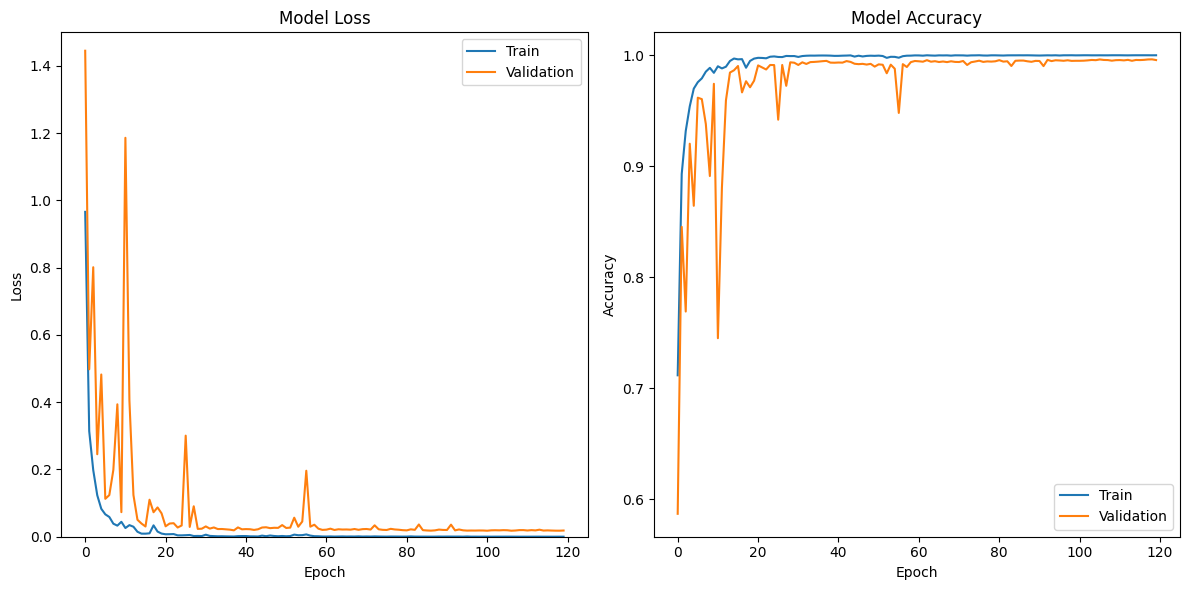

In [8]:
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.ylim(bottom=0, top=1.5)

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.savefig('PlantVillage-2Path-LAB-m4-0.25-History.png')

plt.tight_layout()
plt.show()

In [9]:
import pickle
# Save all histories as a single pickle file (optional)
with open('training_history.pkl', 'wb') as file:
    pickle.dump(history, file)

arr_basefilename = []

for two_paths_second_block in [False, True]:
    for l_ratio in [0.0,0.25,0.5,0.75,1.0]:
        
        basefilename = 'Apple13-twoPath-inception-' + str(two_paths_second_block) + '-' + str(l_ratio)  
        
        arr_basefilename.append(basefilename)
        

print(arr_basefilename)